# Developing Allometric Equations

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [2]:
df = pd.read_csv('final_dataset_filtered.csv') 

In [3]:
#extract relevant columns 
df_relevant = df[['name', 'diameter', 'AGB']]

In [10]:
#combining everything under 80 to 'other'
df_relevant['name'] = df_relevant['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')

/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_88212/4174086897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['name'] = df_relevant['name'].apply(lambda x: x if x in ['Musacea','Guaba','Cacao','Mango'] else 'Otra variedad')


## Exploration of the Data

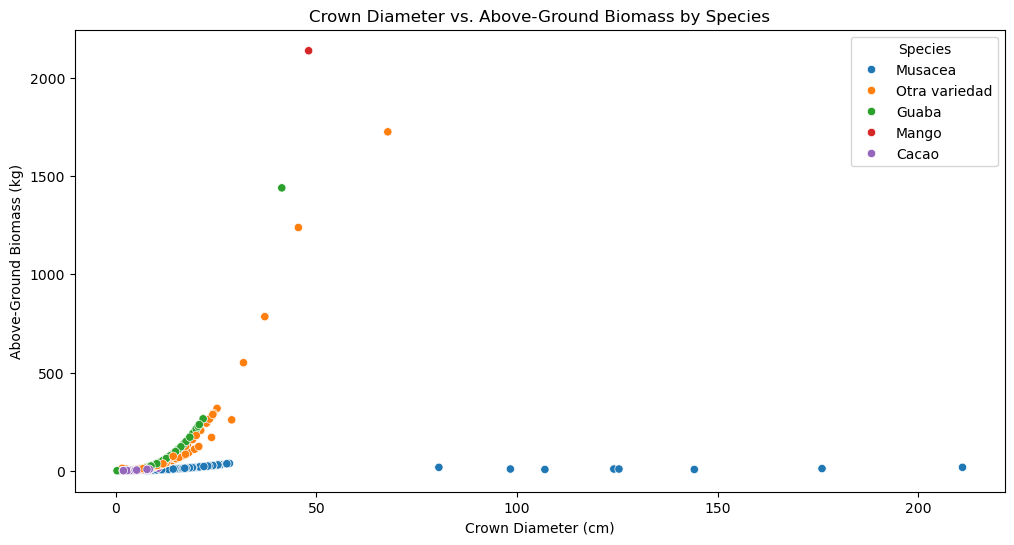

In [11]:
# Plot the relationship between diameter and AGB for different species
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_relevant, x='diameter', y='AGB', hue='name')
plt.title('Crown Diameter vs. Above-Ground Biomass by Species')
plt.xlabel('Crown Diameter (cm)')
plt.ylabel('Above-Ground Biomass (kg)')
plt.legend(title='Species')
plt.show()

## Removing Outliers

In [13]:
def remove_outliers_iqr(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the outlier range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the dataframe to exclude outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

# Apply the function to the diameter and AGB columns
df_cleaned = df_relevant.groupby('name').apply(lambda x: remove_outliers_iqr(x, 'diameter')).reset_index(drop=True)
df_cleaned = df_cleaned.groupby('name').apply(lambda x: remove_outliers_iqr(x, 'AGB')).reset_index(drop=True)


/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_88212/812751015.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_relevant.groupby('name').apply(lambda x: remove_outliers_iqr(x, 'diameter')).reset_index(drop=True)
/var/folders/ym/hz9zm7z56_z32pf0g7q1mxdw0000gp/T/ipykernel_88212/812751015.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('name'

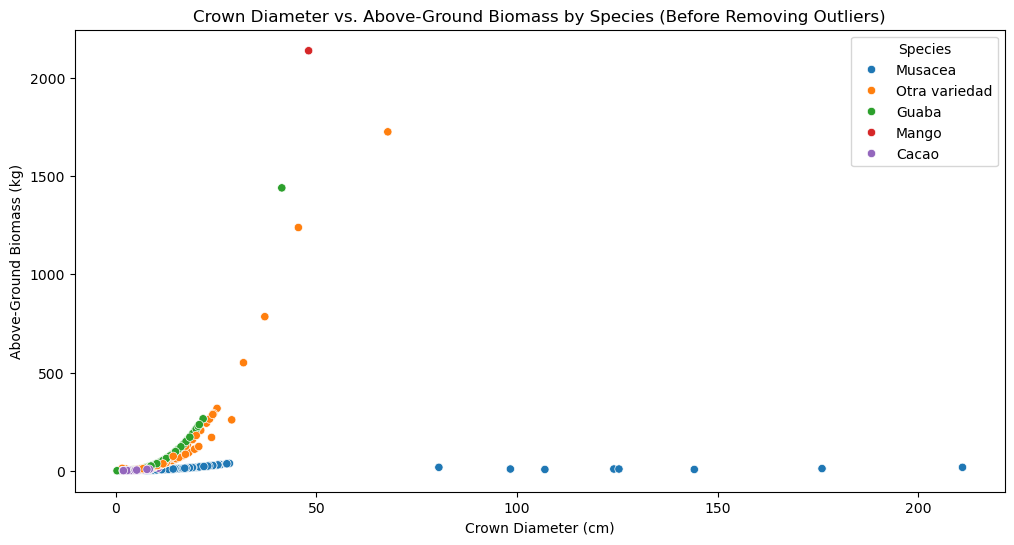

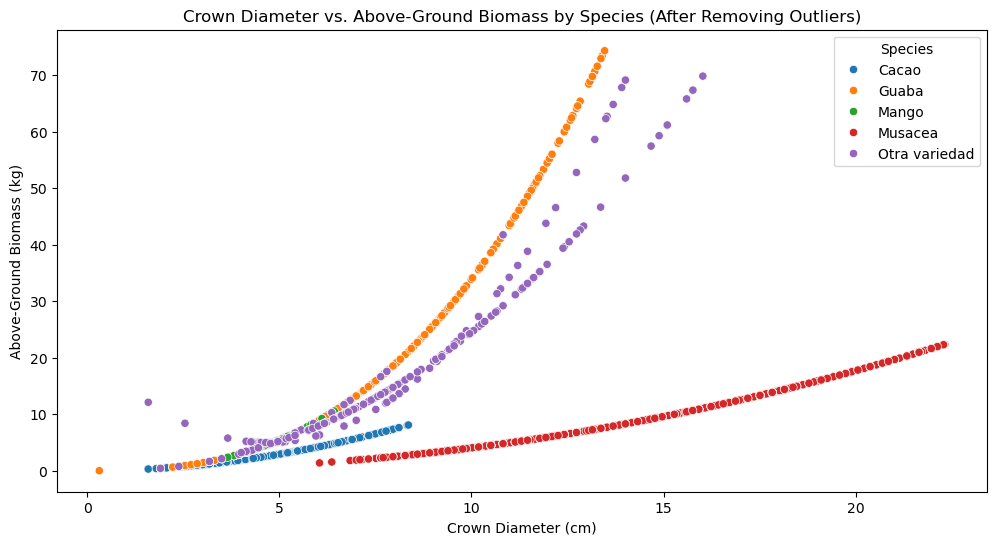

In [14]:
# Visualize before removing outliers
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_relevant, x='diameter', y='AGB', hue='name')
plt.title('Crown Diameter vs. Above-Ground Biomass by Species (Before Removing Outliers)')
plt.xlabel('Crown Diameter (cm)')
plt.ylabel('Above-Ground Biomass (kg)')
plt.legend(title='Species')
plt.show()

# Visualize after removing outliers
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_cleaned, x='diameter', y='AGB', hue='name')
plt.title('Crown Diameter vs. Above-Ground Biomass by Species (After Removing Outliers)')
plt.xlabel('Crown Diameter (cm)')
plt.ylabel('Above-Ground Biomass (kg)')
plt.legend(title='Species')
plt.show()


## Base model: Biomass=a×(Crown Diameter)^b

Species: Cacao
Mean Squared Error: 8.801147895183682e-20
R^2 Score: 1.0
Intercept (a): 0.12079999997641222
Coefficient (b): 1.980000000118874


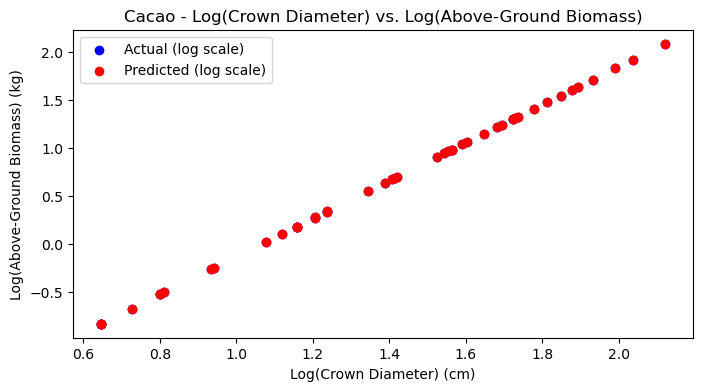

Species: Guaba
Mean Squared Error: 4.998623129150615e-19
R^2 Score: 1.0
Intercept (a): 0.0776247119232094
Coefficient (b): 2.6399999983538023


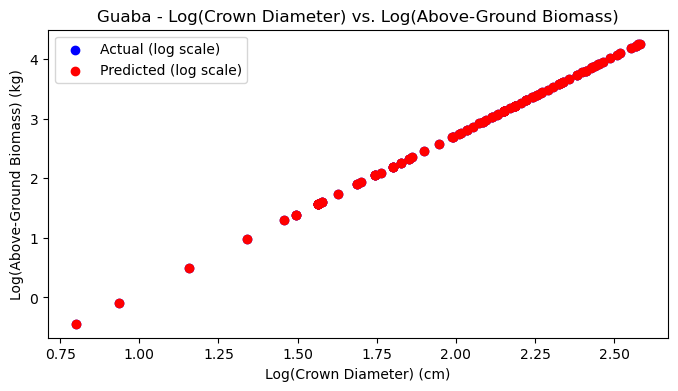

Species: Mango
Mean Squared Error: 2.4556309826159006e-20
R^2 Score: 1.0
Intercept (a): 0.07762471164530067
Coefficient (b): 2.6400000001442856


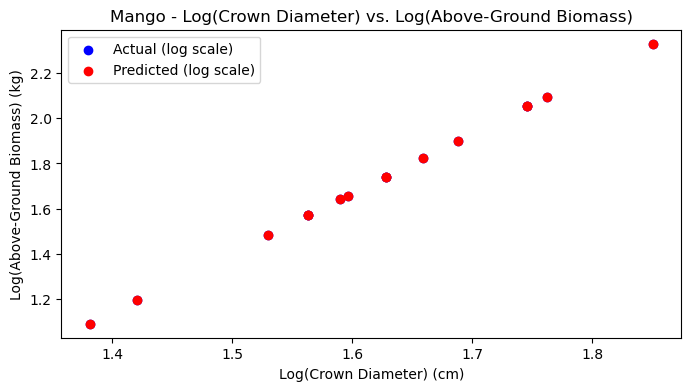

Species: Musacea
Mean Squared Error: 1.4773319065817465e-19
R^2 Score: 1.0
Intercept (a): 0.029999999994907964
Coefficient (b): 2.130000000076527


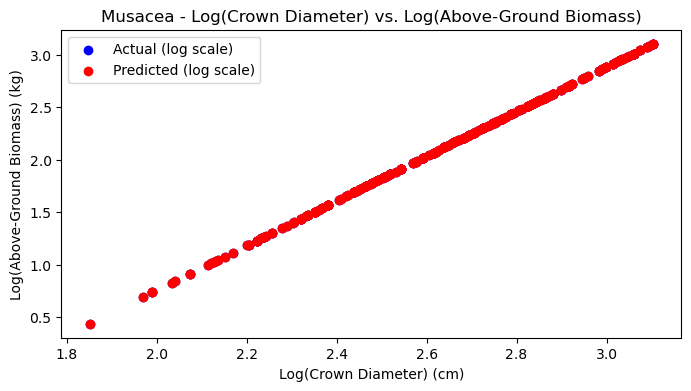

Species: Otra variedad
Mean Squared Error: 0.026702574511115032
R^2 Score: 0.9615234070992343
Intercept (a): 0.2300860297427638
Coefficient (b): 2.023055182888164


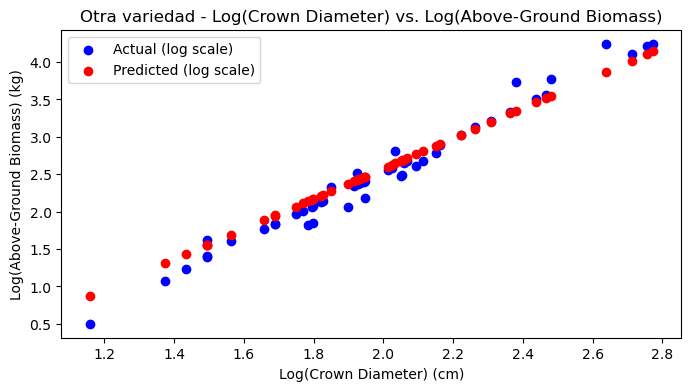

In [21]:
# Function to fit and evaluate a log-log regression model
def fit_and_evaluate_log_log_model(data, species):
    # Filter data for the species
    species_data = data[data['name'] == species]
    
    # Prepare the data (log transformation)
    X = np.log(species_data[['diameter']])
    y = np.log(species_data['AGB'])
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Extract coefficients
    intercept_log = model.intercept_
    coefficient = model.coef_[0]
    intercept = np.exp(intercept_log)  # Convert back to the original scale
    
    print(f'Species: {species}')
    print(f'Mean Squared Error: {mse}')
    print(f'R^2 Score: {r2}')
    print(f'Intercept (a): {intercept}')
    print(f'Coefficient (b): {coefficient}')
    
    # Plot the results
    plt.figure(figsize=(8, 4))
    plt.scatter(X_test, y_test, color='blue', label='Actual (log scale)')
    plt.scatter(X_test, y_pred, color='red', label='Predicted (log scale)')
    plt.title(f'{species} - Log(Crown Diameter) vs. Log(Above-Ground Biomass)')
    plt.xlabel('Log(Crown Diameter) (cm)')
    plt.ylabel('Log(Above-Ground Biomass) (kg)')
    plt.legend()
    plt.show()
    
    return model, intercept, coefficient

# List of unique species
species_list = df_cleaned['name'].unique()

# Fit and evaluate models for each species, and extract coefficients
models = {}
coefficients = {}
for species in species_list:
    model, intercept, coefficient = fit_and_evaluate_log_log_model(df_cleaned, species)
    models[species] = model
    coefficients[species] = (intercept, coefficient)


In [24]:
for species, model in models.items():
    species_data = df_cleaned[df_cleaned['name'] == species]
    X = np.log(species_data[['diameter']])
    y = np.log(species_data['AGB'])
    
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f'Species: {species}')
    print(f'Cross-Validation R^2 Scores: {scores}')
    print(f'Mean R^2 Score: {scores.mean()}')

Species: Cacao
Cross-Validation R^2 Scores: [1. 1. 1. 1. 1.]
Mean R^2 Score: 1.0
Species: Guaba
Cross-Validation R^2 Scores: [1. 1. 1. 1. 1.]
Mean R^2 Score: 1.0
Species: Mango
Cross-Validation R^2 Scores: [1. 1. 1. 1. 1.]
Mean R^2 Score: 1.0
Species: Musacea
Cross-Validation R^2 Scores: [1. 1. 1. 1. 1.]
Mean R^2 Score: 1.0
Species: Otra variedad
Cross-Validation R^2 Scores: [0.9463293  0.96891048 0.5559098  0.96737979 0.97515978]
Mean R^2 Score: 0.8827378310817815


In [23]:
for species, (intercept, coefficient) in coefficients.items():
    print(f'Species: {species}, Intercept (a): {intercept}, Coefficient (b): {coefficient}')

Species: Cacao, Intercept (a): 0.12079999997641222, Coefficient (b): 1.980000000118874
Species: Guaba, Intercept (a): 0.0776247119232094, Coefficient (b): 2.6399999983538023
Species: Mango, Intercept (a): 0.07762471164530067, Coefficient (b): 2.6400000001442856
Species: Musacea, Intercept (a): 0.029999999994907964, Coefficient (b): 2.130000000076527
Species: Otra variedad, Intercept (a): 0.2300860297427638, Coefficient (b): 2.023055182888164
